# co

> Covariance and Coherence Matrix Estimation

In [ ]:
#| default_exp cli/co

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import colorcet

In [ ]:
#| export
import math

import zarr
import cupy as cp
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from dask_cuda import LocalCUDACluster

from decorrelation.co import emperical_co_pc
from decorrelation.cli.utils.logging import get_logger, log_args
from decorrelation.cli.utils.dask import pad_internal, get_cuda_cluster_arg
from decorrelation.cli.utils.chunk_size import get_pc_chunk_size_from_n_az_chunk

from fastcore.script import call_parse

In [ ]:
#| export
@call_parse
@log_args
def de_emperical_co_pc(rslc:str, # input: rslc stack
                       is_shp:str, # input: bool array indicating the SHPs of pc
                       idx:str, # input: bool array indicating pc
                       coh:str, # output: complex coherence matrix for pc
                       coh_ave:str, # output: average value of coherence matrix magnitude
                       az_chunk_size:int=None, # azimuth chunk size, optional. Default: the azimuth chunk size in rslc stack
                       n_pc_chunk:int=None, # number of point chunk, optional.
                       pc_chunk_size:int=None, # chunk size of output zarr dataset, optional. Default: same as is_shp
                       log=None, # log file. Default: no log file
                       ):
    '''estimate emperical coherence matrix on point cloud data.
    Only one of `n_pc_chunk` and `pc_chunk_size` needs to be setted. The other one is automatically determined.
    If all of them are not setted, the `n_pc_chunk` will be setted as the number of azimuth chunks.
    '''
    rslc_path = rslc
    is_shp_path = is_shp
    idx_path = idx
    coh_path = coh
    coh_ave_path = coh_ave
    logger = get_logger(logfile=log)

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path, rslc_zarr)
    assert rslc_zarr.ndim == 3, "rslc dimentation is not 3."

    is_shp_zarr = zarr.open(is_shp_path,mode='r')
    logger.zarr_info(is_shp_path, is_shp_zarr)
    assert is_shp_zarr.ndim == 3, "is_shp dimentation is not 3."

    idx_zarr = zarr.open(idx_path,mode='r')
    logger.zarr_info(idx_path, idx_zarr)
    assert idx_zarr.ndim == 2, "idx dimentation is not 2."
    logger.info('loading idx into memory.')
    idx = zarr.open(idx_path,mode='r')[:]

    az_win, r_win = is_shp_zarr.shape[1:]
    az_half_win = int((az_win-1)/2)
    r_half_win = int((r_win-1)/2)
    logger.info(f'got azimuth window size and half azimuth window size from is_shp shape: {az_win}, {az_half_win}')
    logger.info(f'got range window size and half range window size from is_shp shape: {r_win}, {r_half_win}')

    if not az_chunk_size:
        az_chunk_size = rslc_zarr.chunks[0]
        logger.info('using default parallel processing azimuth chunk size from rslc dataset.')
    logger.info('parallel processing azimuth chunk size: '+str(az_chunk_size))

    logger.info('starting dask CUDA local cluster.')
    with LocalCUDACluster(**get_cuda_cluster_arg()) as cluster, Client(cluster) as client:
        logger.info('dask local CUDA cluster started.')

        logger.info('create raster bool array is_pc from idx')
        np_is_pc = np.zeros(rslc_zarr.shape[:2],dtype=bool)
        np_is_pc[(idx[0],idx[1])] = True
        logger.info('create dask bool array is_pc')
        cpu_is_pc = da.from_array(np_is_pc,chunks=(az_chunk_size,-1))
        logger.darr_info('is_pc', cpu_is_pc)

        logger.info('Using azimuth chunk size as the processing chunk size.')
        logger.info('Calculate point chunk size')
        cpu_idx = da.nonzero(cpu_is_pc)
        idx_0 = cpu_idx[0]
        process_pc_chunk_size = idx_0.compute_chunk_sizes().chunks[0]
        logger.info(f'Point chunk size: {process_pc_chunk_size}')

        cpu_rslc = da.from_zarr(rslc_path,chunks=(az_chunk_size,*rslc_zarr.shape[1:]))
        logger.darr_info('rslc', cpu_rslc)

        cpu_is_shp = da.from_zarr(is_shp_path,chunks=(process_pc_chunk_size,*is_shp_zarr.shape[1:]))
        logger.darr_info('is_shp', cpu_is_shp)

        depth = {0:az_half_win, 1:r_half_win, 2:0}; boundary = {0:'none',1:'none',2:'none'}
        cpu_rslc_overlap = da.overlap.overlap(cpu_rslc,depth=depth, boundary=boundary)
        logger.info('setting shared boundaries between rlsc chunks.')
        logger.darr_info('rslc_overlap', cpu_rslc_overlap)

        depth = {0:az_half_win, 1:r_half_win}
        cpu_is_pc_padded = pad_internal(cpu_is_pc,depth=depth)
        logger.info('padding zero between is_pc chunks.')
        logger.darr_info('is_pc_padded', cpu_is_pc_padded)

        logger.info(f'estimating coherence matrix.')
        rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
        is_pc_padded = cpu_is_pc_padded.map_blocks(cp.asarray)
        is_shp = cpu_is_shp.map_blocks(cp.asarray)

        emperical_co_pc_delayed = delayed(emperical_co_pc,pure=True,nout=2)

        is_pc_padded_delayed = is_pc_padded.to_delayed()
        is_pc_padded_delayed = np.squeeze(is_pc_padded_delayed,axis=-1)
        rslc_overlap_delayed = rslc_overlap.to_delayed()
        rslc_overlap_delayed = np.squeeze(rslc_overlap_delayed,axis=(-2,-1))
        is_shp_delayed = is_shp.to_delayed()
        is_shp_delayed = np.squeeze(is_shp_delayed,axis=(-2,-1))

        coh_delayed = np.empty_like(rslc_overlap_delayed,dtype=object)
        idx_delayed = np.empty_like(rslc_overlap_delayed,dtype=object)

        nimage = rslc_overlap.shape[-1]
        with np.nditer(rslc_overlap_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                ix = it.multi_index
                idx_delayed[ix] = delayed(cp.where)(is_pc_padded_delayed[ix])
                coh_delayed[ix] = emperical_co_pc_delayed(rslc_overlap_delayed[ix],idx_delayed[ix],is_shp_delayed[ix])[1]
                chunk_shape = (is_shp.blocks[ix].shape[0],nimage,nimage)
                dtype = rslc_overlap.dtype
                coh_delayed[ix] = da.from_delayed(coh_delayed[ix],shape=chunk_shape,meta=cp.array((),dtype=dtype))

        coh = da.block(coh_delayed.reshape(*coh_delayed.shape,1,1).tolist())
        cpu_coh = coh.map_blocks(cp.asnumpy)
        logger.info(f'got coherence matrix.'); logger.darr_info('coh', cpu_coh)

        # zarr do not support irregular chunk size
        pc_chunk_size = get_pc_chunk_size_from_n_az_chunk('rslc','coh',cpu_rslc.shape[0],az_chunk_size,coh.shape[0],logger,pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)
        cpu_coh = cpu_coh.rechunk((pc_chunk_size,nimage,nimage))
        logger.info('rechunking_coh to chunk size (for saving with zarr): '+str(cpu_coh.chunksize))
        logger.darr_info('coh', cpu_coh)

        cpu_coh_ave = da.abs(cpu_coh).mean(axis=0); logger.info('get average coherence matrix magnitude.')
        logger.darr_info('coh_ave', cpu_coh_ave)

        logger.info('saving coh and coh_ave.')
        _cpu_coh = cpu_coh.to_zarr(coh_path,overwrite=True,compute=False)
        _cpu_coh_ave = cpu_coh_ave.to_zarr(coh_ave_path,overwrite=True,compute=False)

        logger.info('computing graph setted. doing all the computing.')
        #This function is really slow just because the coherence is very big and rechunk and saving takes too much time.
        # I do not find any solution to it.
        futures = client.persist([_cpu_coh,_cpu_coh_ave])
        progress(futures,notebook=False)
        da.compute(futures)
        # pdb.set_trace()
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
rslc = './raw/rslc.zarr'
ds_can_is_shp = './shp/ds_can_is_shp.zarr'
ds_can_idx = './shp/ds_can_idx.zarr'
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_coh_ave = './co/ds_can_coh_ave.zarr'
az_chunk_size = 1000
pc_chunk_size = None
log = './co/co.log'

In [ ]:
%%time
de_emperical_co_pc(rslc,ds_can_is_shp,ds_can_idx,ds_can_coh,ds_can_coh_ave,log=log)

2023-10-19 20:43:19 - de_emperical_co_pc - INFO - fetching args:
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - rslc = './raw/rslc.zarr'
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - is_shp = './shp/ds_can_is_shp.zarr'
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - idx = './shp/ds_can_idx.zarr'
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - coh = './co/ds_can_coh.zarr'
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - coh_ave = './co/ds_can_coh_ave.zarr'
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - az_chunk_size = None
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - n_pc_chunk = None
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - pc_chunk_size = None
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - log = './co/co.log'
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - fetching args done.
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - ./raw/rslc.zarr zarray shape: (2500, 1834, 17)
2023-10-19 20:43:19 - de_emperical_co_pc - INFO - ./raw/rslc.zarr zarray chunks: 

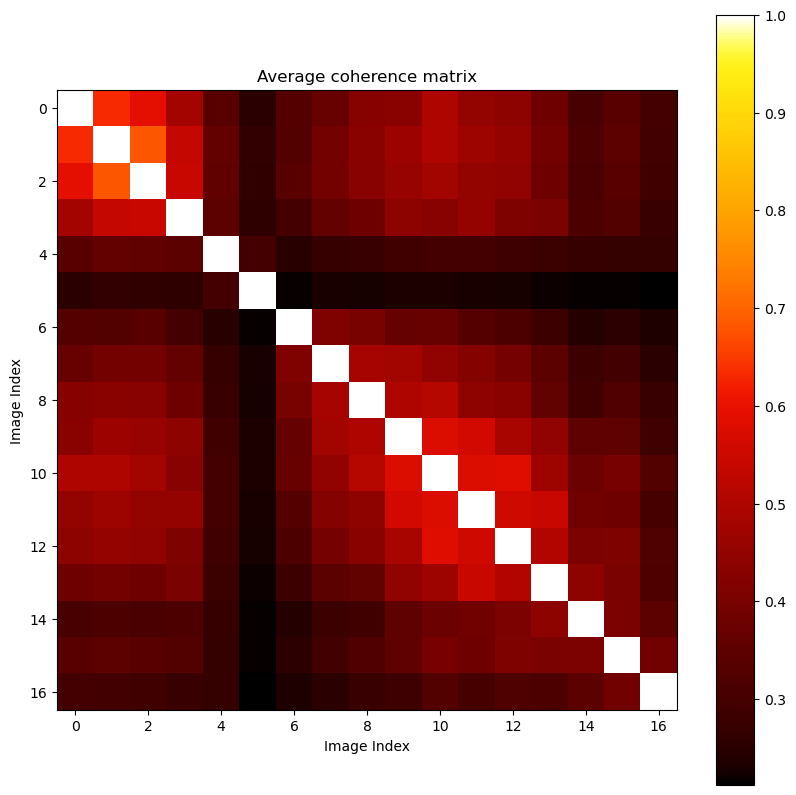

In [ ]:
ds_can_coh_ave_zarr = zarr.open(ds_can_coh_ave,'r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(ds_can_coh_ave_zarr[:],cmap=colorcet.cm.fire)
ax.set(title='Average coherence matrix',xlabel='Image Index',ylabel='Image Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
!de_emperical_co_pc -h

usage: de_emperical_co_pc [-h] [--az_chunk_size AZ_CHUNK_SIZE]
                          [--n_pc_chunk N_PC_CHUNK]
                          [--pc_chunk_size PC_CHUNK_SIZE] [--log LOG]
                          rslc is_shp idx coh coh_ave

estimate emperical coherence matrix on point cloud data. Only one of
`n_pc_chunk` and `pc_chunk_size` needs to be setted. The other one is
automatically determined. If all of them are not setted, the `n_pc_chunk` will
be setted as the number of azimuth chunks.

positional arguments:
  rslc                           input: rslc stack
  is_shp                         input: bool array indicating the SHPs of pc
  idx                            input: bool array indicating pc
  coh                            output: complex coherence matrix for pc
  coh_ave                        output: average value of coherence matrix
                                 magnitude

options:
  -h, --help                     show this help message and exit
  --az_chunk_size

In [ ]:
%%time
#| hide
import numpy as np
import zarr
import cupy as cp
from decorrelation.shp import ks_test
rslc_zarr = zarr.open('./raw/rslc.zarr',mode='r')
ds_can_is_shp_zarr = zarr.open('./shp/ds_can_is_shp.zarr','r')
ds_can_idx_zarr = zarr.open('./shp/ds_can_idx.zarr','r')

rslc_cpu = rslc_zarr[:]; rslc = cp.asarray(rslc_cpu)
ds_can_is_shp_cpu = ds_can_is_shp_zarr[:]; ds_can_is_shp = cp.asarray(ds_can_is_shp_cpu)
ds_can_idx_cpu = ds_can_idx_zarr[:]; ds_can_idx = cp.asarray(ds_can_idx_cpu)

ds_can_coh = emperical_co_pc(rslc,ds_can_idx,ds_can_is_shp)[1]

ds_can_coh_cpu = cp.asnumpy(ds_can_coh)
nimage = rslc.shape[-1]
ds_can_chunk_size = math.ceil(ds_can_coh.shape[0]/3)
test_ds_can_coh_zarr = zarr.open('./co/test_ds_can_coh.zarr','w',shape=ds_can_coh_cpu.shape,chunks=(ds_can_chunk_size,nimage,nimage),dtype=ds_can_coh_cpu.dtype)
test_ds_can_coh_zarr[:] = ds_can_coh_cpu

CPU times: user 3.72 s, sys: 3.13 s, total: 6.85 s
Wall time: 4.74 s


In [ ]:
#| hide
ds_can_coh_result = zarr.open('./co/ds_can_coh.zarr','r')[:]
ds_can_coh_test = zarr.open('./co/test_ds_can_coh.zarr','r')[:]
np.testing.assert_array_equal(ds_can_coh_cpu,ds_can_coh_result)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()